# Poisson Kriging - Area to Area Kriging

## Table of Contents:

1. Load areal and point data,
2. Load semivariogram (regularized),
3. Remove 10% of areal dataset,
4. Predict values at unknown locations,
5. Analyse Forecast Bias and Root Mean Squared Error of prediction.

## Level: Advanced

## Changelog

| Date | Change description | Author |
|------|--------------------|--------|
| 2022-08-27 | Tutorial updated for the 0.3.0 version of the package | @SimonMolinsky |
| 2021-12-14 | Sill selection was upgraded: now optimal sill is derived from the grid search within `TheoreticalSemivariogram` class | @SimonMolinsky |
| 2021-12-13 | Changed behavior of `select_values_in_range()` function | @SimonMolinsky |
| 2021-12-11 | Behavior of `prepare_kriging_data()` function has benn changed | @SimonMolinsky |
| 2021-05-28 | Updated paths for input/output data | @SimonMolinsky |
| 2021-05-11 | Refactored TheoreticalSemivariogram class | @SimonMolinsky |
| 2021-03-31 | Update related to the change of semivariogram weighting. Updated cancer rates data. | @SimonMolinsky |

## Introduction

To start this tutorial it is required to understand concepts in the **Ordinary and Simple Kriging** and **Semivariogram Regularization** tutorials.

Poisson Kriging technique is used to model spatial count data. We are analyzing special case where data is counted over areas. Those areas may have irregular shapes and sizes beacuse they represent administrative regions. 

In this tutorial we try to predict rates of Breast Cancer in Pennsylvania counties. Along with areal data we use U.S. Census 2010 data for population blocks.

> Breast cancer rates data is stored in the shapefile in folder `sample_data/areal_data/cancer_data.shp`.

> Population blocks data is stored in the shapefile in folder `sample_data/population_data/cancer_population_base.shp`

In tutorial **Poisson Kriging - Centroid based approach** we've made assumption that all areas have the same size and shape. This wasn't true. Now we use Area-to-Area Kriging technique and predict and evaluate missing values.

Area-to-Area and Area-to-Point Poisson Kriging are slower than simplified Kriging with Centroids, but gives more reliable results because they are tuned to areal size and shape.

This tutorial covers following steps:

1. Read and explore data,
2. Load semivariogram model,
3. Prepare training and test data,
4. Predict values of unknown locations and calculate forecast bias and root mean squared error,
5. Analyse error metrics.

## 1) Read and explore data

In [1]:
import numpy as np
import pandas as pd

from pyinterpolate.variogram import TheoreticalVariogram
from pyinterpolate.processing.preprocessing.blocks import Blocks, PointSupport
from pyinterpolate.kriging.models.block.area_to_area_poisson_kriging import area_to_area_pk

In [2]:
DATASET = 'samples/regularization/cancer_data.gpkg'
OUTPUT = 'samples/regularization/regularized_variogram.json'
POLYGON_LAYER = 'areas'
POPULATION_LAYER = 'points'
POP10 = 'POP10'
GEOMETRY_COL = 'geometry'
POLYGON_ID = 'FIPS'
POLYGON_VALUE = 'rate'

blocks = Blocks()
blocks.from_file(DATASET, value_col=POLYGON_VALUE, index_col=POLYGON_ID, layer_name=POLYGON_LAYER)

point_support = PointSupport()
point_support.from_files(point_support_data_file=DATASET,
                         blocks_file=DATASET,
                         point_support_geometry_col=GEOMETRY_COL,
                         point_support_val_col=POP10,
                         blocks_geometry_col=GEOMETRY_COL,
                         blocks_index_col=POLYGON_ID,
                         use_point_support_crs=True,
                         point_support_layer_name=POPULATION_LAYER,
                         blocks_layer_name=POLYGON_LAYER)

<AxesSubplot:>

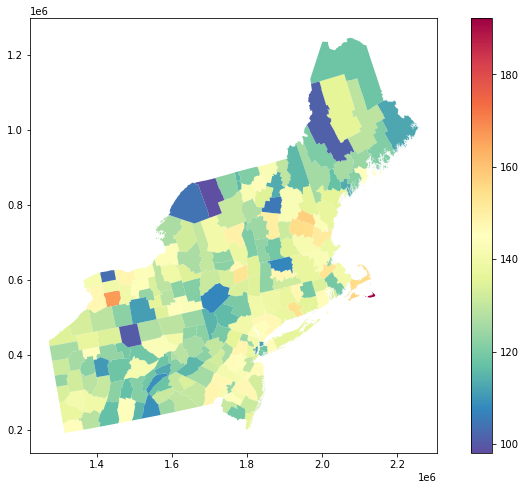

In [3]:
# Lets take a look into a map of areal counts

blocks.data.plot(column=blocks.value_column_name, cmap='Spectral_r', legend=True, figsize=(12, 8))

#### Clarification: 

It is good idea to look into the spatial patterns in dataset and to visually check if our data do not have any NaN values. We use geopandas GeoDataFrame plot function for it with color map which is diverging color classes well.

## 2) Load semivariogram model

In this step we load regularized semivariogram from the tutorial **Semivariogram Regularization (Intermediate)**. You can always perform semivariogram regulariztion along with the Poisson Kriging but it is a very long process and it is more convenient to separate those two steps.

In [4]:
semivariogram = TheoreticalVariogram()  # Create TheoreticalSemivariogram object
semivariogram.from_json('output/regularized_model.json')  # Load regularized semivariogram

## 3) Prepare training and test data

We simply remove 10% of random ID's from areal dataset (the same for points) and create four arrays: two training arrays with areal and point geometry and values and two test arrays with the same categories of data.

In [5]:
# Remove 10% of rows (values) to test our model

def create_test_areal_set(areal_dataset: Blocks, points_dataset: PointSupport, frac=0.4):
    """

    Parameters
    ----------
    areal_dataset : Blocks
    points_dataset : PointSupport
    frac : float

    Returns
    -------
    : List
        [[training_areas, test_areas, training_points, test_points]]
            equal to:
        [np.ndarray, np.ndarray, np.ndarray, np.ndarray]
            where:
        - areas: [[block index, centroid x, centroid y, value]]
        - point support: [[block id, x, y, value]]
    """
    block_id_col = areal_dataset.index_column_name
    block_data = areal_dataset.data.copy()
    all_ids = block_data[block_id_col].unique()
    training_set_size = int(len(all_ids) * (1 - frac))

    training_ids = np.random.choice(all_ids,
                                    size=training_set_size,
                                    replace=False)

    training_areas = block_data[block_data[block_id_col].isin(training_ids)]
    training_areas = training_areas[[block_id_col, 'centroid.x', 'centroid.y', areal_dataset.value_column_name]].values
    test_areas = block_data[~block_data[block_id_col].isin(training_ids)]
    test_areas = test_areas[[block_id_col, 'centroid.x', 'centroid.y', areal_dataset.value_column_name]].values

    ps_data = points_dataset.point_support.copy()
    ps_ids = points_dataset.block_index_column

    training_points = ps_data[ps_data[ps_ids].isin(training_ids)]
    training_points = training_points[[ps_ids,
                                       points_dataset.x_col,
                                       points_dataset.y_col,
                                       points_dataset.value_column]].values
    test_points = ps_data[~ps_data[ps_ids].isin(training_ids)]
    test_points = test_points[[ps_ids,
                               points_dataset.x_col,
                               points_dataset.y_col,
                               points_dataset.value_column]].values


    output = [training_areas, test_areas, training_points, test_points]
    return output

ar_train, ar_test, pt_train, pt_test = create_test_areal_set(blocks, point_support)

## 4) Predict values at unknown locations and calculate forecast bias and root mean squared error

Do you know scikit-learn's fit-predict-transform estimation procedure? With Kriging it is more complicated because we are fitting semivariogram model to data and we pass this fitted model into kriging estimator. That's why package with *TheoreticalSemivariogram()* class is named **fit_semivariance**.
You may start work with predictions with fitted semivariogram model. Area-to-Area Poisson Kriging takes three arguments during initialization:

=> semivariogram model (fitted semivariogram model),

=> known areas (training set),

=> known points (training set).

After initilization you may perform prediction. This process requires you to control two hyperparameters:

=> **number of observations** (the most important parameter - how many neighbors are affecting your area of analysis),

Algorithm in the cell below iteratively picks one area from the test set and perform prediction. Then forecast bias which is difference between real and predicted value is calculated. Forecast Bias is useful to understand if our algorithm predictions are too low or too high (under- or overestimation). The next parameter is Root Mean Squared Error. This kind of measure tells us more about outliers and very large differences between predictions and real values. We will see it in the last part of tutorial.

Your work with Poisson Kriging (or Kriging) will be usually the same:
- prepare training and test data,
- use training data to prepare semivariogram model,
- test different hyperparameters with a test set to find optimal number of neighbors which are affecting your area of analysis,
- forecast into unknown areas OR perform data smoothing.

In [12]:
number_of_obs = 4

predslist = []
for unknown_area in ar_test:
    upts = pt_test[pt_test[:, 0] == unknown_area[0]]
    upts = upts[:, 1:]
    # [unknown block index, prediction, error]
    try:
        kriging_preds = area_to_area_pk(
            semivariogram_model=semivariogram,
            blocks=ar_train,
            point_support=pt_train,
            unknown_block=unknown_area[:-1],
            unknown_block_point_support=upts,
            number_of_neighbors=number_of_obs,
            raise_when_negative_prediction=True,
            raise_when_negative_error=True
        )
    except ValueError:
        predslist.append([unknown_area[0], np.nan, np.nan, np.nan, np.nan])
    else:
        rmse = np.sqrt((kriging_preds[1] - unknown_area[-1])**2)
        fb = unknown_area[-1] - kriging_preds[1]
        kriging_preds.extend([rmse, fb])
        predslist.append(kriging_preds)

In [13]:
kriged_predictions = np.array(predslist)
pred_df = pd.DataFrame(data=kriged_predictions[:, 1:],
                       index=kriged_predictions[:, 0],
                       columns=['predicted', 'err', 'rmse', 'fb'])  # Store results in DataFrame

## 5) Analyze Forecast Bias and Root Mean Squared Error of prediction

The last step is analysis of errors. We plot two histograms: of forecast bias and of root mean squared error then we calculate base statistics of a dataset.

<AxesSubplot:ylabel='Frequency'>

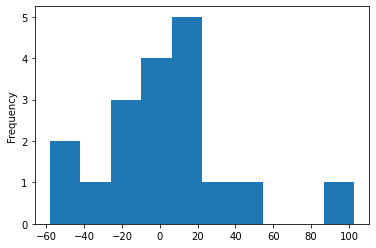

In [14]:
# Show histograms of errors

pred_df['fb'].plot.hist(bins=10)

<AxesSubplot:ylabel='Frequency'>

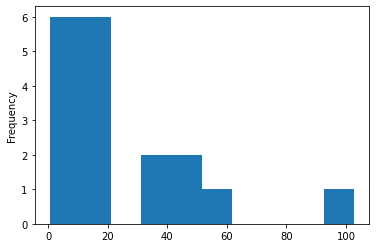

In [15]:
pred_df['rmse'].plot.hist(bins=10)

In [16]:
pred_df.describe()

,predicted,err,rmse,fb
count,18.000000,18.000000,18.000000,18.000000
mean,132.326384,7.079904,25.004905,3.695838
std,33.653437,4.245333,25.873860,36.290747
min,44.254068,1.207751,0.576752,-58.154160
25%,127.825974,3.856511,7.016140,-12.744211
50%,135.402511,7.670986,15.429341,1.917038
75%,149.185938,9.093050,36.028226,16.184041
max,191.654160,17.564486,102.745932,102.745932


#### Clarification:

Analysis of **Forecast Bias** and **Root Mean Squared Error** - their distribution and basic properties - could be a very useful tool to analyze model performance. However, take in mind that table above is a single test case (realization) and can be very misleading. Good idea is to repeat test dozens of times with a different training/test set division each time. After this we average results from multiple tests and we get an insight how our model behaves.

##### NOTE:

Those results are not decisive. Our sample is very small and output could be related to very fortunate sampling over areas. The good idea is to repeat experiment multiple times with other samples and average results to find out how well model is performing.

---

## Where to go?

### Next steps:

* [Poisson Kriging - Centroid based]()
* [Poisson Kriging - Area to Point]()

### Additional materials:

* [Semivariogram Regularization]()
* [Blocks to points Ordinary Kriging interpolation]()